# Central Measures Filter

In [13]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


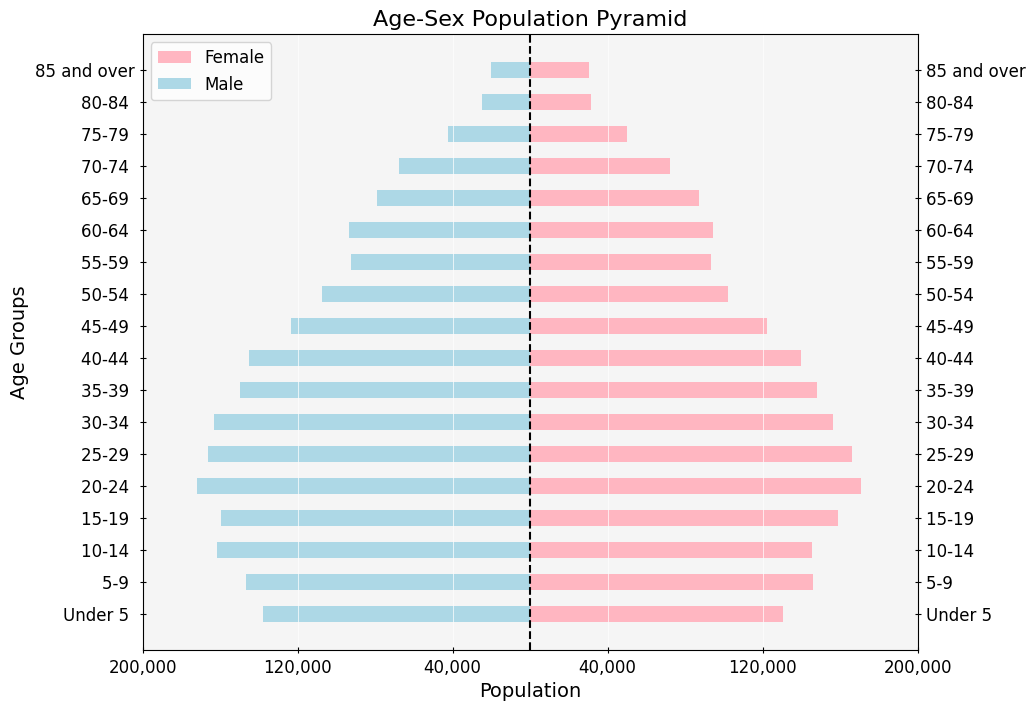

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sqlalchemy import create_engine, text
import numpy as np

# Database connection configuration
db_user = 'postgres'  # replace with your PostgreSQL username
db_password = 'Blubberboil'  # replace with your PostgreSQL password
db_host = 'localhost'
db_port = '5432'
db_name = 'sandbox'

# Database URL
db_url = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'

# Create SQLAlchemy engine
engine = create_engine(db_url)

# Parameterized values
year = 2023
geounit = 'state'
filter_condition = "cm.val < 35" # S0101_C01_032E total population's median age


# SQL query with parameters
query = text(f'''
select hv.var_id, sv.var_label, sum(p.count) as val /*distinct l.year, hg.geoname, cm.val as median_age*/
from cpreport.pop_pyr p
left join cprefined.link_year_geo_var l on p.link_key = l.link_key
left join (
    select cm.geo_key, cm.year, cm.val
    from cpreport.central_measures cm
    left join cprefined.link_year_geo_var l on cm.link_key = l.link_key
    left join cprefined.hub_var hv on l.var_key = hv.var_key
    left join cprefined.hub_geo hg on l.geo_key = hg.geo_key
    left join cprefined.sat_geo sg on l.geo_key = sg.geo_key
    where hv.var_id = 'S0101_C01_032E'
) cm on l.geo_key = cm.geo_key and l.year = cm.year
left join cprefined.hub_var hv on l.var_key = hv.var_key
left join cprefined.hub_geo hg on l.geo_key = hg.geo_key
left join cprefined.sat_geo sg on l.geo_key = sg.geo_key /*for query by geounit*/
left join cprefined.sat_var sv on l.var_key = sv.var_key
where {filter_condition}
 and sg.geounit = :geounit
 and l.year = :year
group by hv.var_id, sv.var_label 
ORDER BY
  CASE 
    WHEN sv.var_label LIKE '%Female%' THEN 1
    WHEN sv.var_label LIKE '%Male%' THEN 2
    ELSE 3
  end,
  CASE 
    WHEN sv.var_label LIKE '%Under 5 years%' THEN 1
    WHEN sv.var_label LIKE '%5 to 9 years%' THEN 2
    WHEN sv.var_label LIKE '%10 to 14 years%' THEN 3
    WHEN sv.var_label LIKE '%15 to 19 years%' THEN 4
    WHEN sv.var_label LIKE '%20 to 24 years%' THEN 5
    WHEN sv.var_label LIKE '%25 to 29 years%' THEN 6
    WHEN sv.var_label LIKE '%30 to 34 years%' THEN 7
    WHEN sv.var_label LIKE '%35 to 39 years%' THEN 8
    WHEN sv.var_label LIKE '%40 to 44 years%' THEN 9
    WHEN sv.var_label LIKE '%45 to 49 years%' THEN 10
    WHEN sv.var_label LIKE '%50 to 54 years%' THEN 11
    WHEN sv.var_label LIKE '%55 to 59 years%' THEN 12
    WHEN sv.var_label LIKE '%60 to 64 years%' THEN 13
    WHEN sv.var_label LIKE '%65 to 69 years%' THEN 14
    WHEN sv.var_label LIKE '%70 to 74 years%' THEN 15
    WHEN sv.var_label LIKE '%75 to 79 years%' THEN 16
    WHEN sv.var_label LIKE '%80 to 84 years%' THEN 17
    WHEN sv.var_label LIKE '%85 years and over%' THEN 18
    ELSE 19
  END
''')

# Execute the query and fetch the data
with engine.connect() as conn:
    df = pd.read_sql(query, conn, params={'year': year, 'geounit':geounit})

# Convert var_label column into labels for UI
labs = df.var_label.str.replace('Total', '', regex=False).str.split('!!', expand=True)[[1, 2, 4]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
labs = labs.str.replace('years', '').str.replace(' to ', '-').str.replace('  ', ' ')
df['labels'] = labs

# Extracting Sex and Age_Years columns using regex
df[['Sex', 'Age_Years']] = df['labels'].str.extract(r'(Female|Male) population (.*)')
df['Age_Group'] = df['Age_Years']

# Determine the highest value in the data set
max_value = df['val'].max()

# Function to get tick range
def get_tick_range(max_value, num_ticks):
    magnitude = 10 ** (len(str(int(max_value))) - 2)
    base_ticks = [1 * magnitude, 2 * magnitude, 5 * magnitude]
    try:
        step = min(t for t in base_ticks if t >= max_value / (num_ticks - 1))
    except ValueError:
        step = base_ticks[-1]
    interval = step
    tick_range = np.arange(0, max_value + interval, interval)
    return tick_range

# Set number of ticks (total including negative and positive)
n_ticks = 6

# Get the tick range
tick_range = get_tick_range(max_value, n_ticks // 2 + 1)

# Adjust to have equal intervals
tick_values = np.linspace(-tick_range[-1], tick_range[-1], n_ticks)

# Create population pyramid chart
fig, ax = plt.subplots(figsize=(10, 8))

# Separate data for females and males
females = df[df['Sex'] == 'Female']
males = df[df['Sex'] == 'Male']

# Plot female population
ax.barh(females['Age_Group'], females['val'], color='lightpink', label='Female', height=0.5)

# Plot male population (negative values for left side)
ax.barh(males['Age_Group'], -males['val'], color='lightblue', label='Male', height=0.5)

# Customize ticks and labels
ax.set_xticks(tick_values)
ax.set_xlim([-tick_range[-1], tick_range[-1]])
ax.set_xlabel('Population', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Add vertical line for zero population and grid lines for better visibility
ax.axvline(0, color='black', linestyle='--')
ax.xaxis.grid(True, which='both', color='white', linestyle='-', linewidth=0.5)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{abs(int(x)):,}'))

# Set background color to gray
ax.set_facecolor('#f5f5f5')

# Add labels and title
ax.set_ylabel('Age Groups', fontsize=14)
ax.set_title('Age-Sex Population Pyramid', fontsize=16)

# Ensure y-axis has tick marks and labels on both sides
ax.tick_params(axis='both', which='both', length=5, direction='inout', left=True, right=True)
ax.yaxis.set_tick_params(labelleft=True, labelright=True)

# Move legend to the top left and match its label size to the y-axis tick labels
ax.legend(loc='upper left', fontsize=12)

# Show the plot
plt.show()
